# Lista 5 de Otimização Natural

## 1ª Questão

### Exercício 7 do capítulo 5

Implement an EP for the Ackley function with n = 30. Make 100 runs, storing the best value foudn in each, and then calculate the mean and standard deviation of these values. Compare your results with those from exercises 5 and 6 in Chap. 4.

In [4]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    'paper',
    'white',
    'colorblind',
    font_scale=2.2,
    rc={
        'lines.linewidth': 2,
        'text.usetex': True,
        'figure.figsize': (8.0, 6.0),
        'image.interpolation': 'nearest',
        'image.cmap': 'gray'
    },
)

In [187]:
# Definições das funções usadas no exercícios.


## INICIALIZA A POPULAÇÃO
def init_indv_rand(num_alelo):
    return [b for b in np.random.uniform(low=-1, high=1, size=num_alelo)]

def eval_pop_rand(num_indv, num_alelo):
    return np.array(list(map(lambda i: init_indv_rand(num_alelo), range(num_indv))))


## INICIALIZA OS DESVIOS PADRÃO
def init_sigma_rand(num_alelo):
    return [b for b in np.random.normal(loc=0.0, scale=1.0, size=num_alelo)]

def eval_sigma_rand(num_indv, num_alelo):
    return np.array(list(map(lambda i: init_sigma_rand(num_alelo), range(num_indv))))


## FUNÇÃO A SER MINIMIZADA
def ackley_func(x):
    n = len(x)
    return -20*np.exp(-0.2*np.sqrt(1/n * np.sum(x**2))) - np.exp(1/n * np.sum(np.cos(2*np.pi*x))) + 20 + np.exp(1)


## FITNESS DA POPULAÇÃO
def eval_fitness(populacao):
    return list(map(lambda i: ackley_func(populacao[i]), range(len(populacao))))


## MUTAÇÃO
def mutation(x, sigma):
    global_uni = np.random.normal(loc=0.0, scale=1.0)
    local_uni = np.random.normal(loc=0.0, scale=1.0, size=len(sigma))    
    alpha = 0.2

    sigma_new = sigma*(1 + alpha*global_uni)
    x_new = x + sigma*local_uni   
    
    eps = 0.02
    for each_sigma in sigma:
        if each_sigma < eps: each_sigma = eps       
    
#     if (ackley_func(x_new) < ackley_func(x)): (x, sigma) = (x_new, sigma_new)
    (x, sigma) = (x_new, sigma_new)
    return x, sigma

def eval_mutation(children, sigma_children, num_filhos=None):
    if num_filhos == None: num_filhos = len(children)
    
    x, sigma = [], []
    for child, sigma_child in zip(children, sigma_children):
        x_new, sigma_new = mutation(child, sigma_child)
        x.append(x_new)
        sigma.append(sigma_new)
        
    pop_chil = np.vstack((children,np.array(x)))
    pop_chil_sigma = np.vstack((sigma_children,np.array(sigma)))
    return pop_chil, pop_chil_sigma

def mutation_CEP(x, sigma):
    global_uni = np.random.normal(loc=0.0, scale=1.0)
    local_uni = np.random.normal(loc=0.0, scale=1.0, size=len(sigma))
    
    x_candidato = x + sigma*local_uni   
    
    if (ackley_func(x_candidato) < ackley_func(x)):
        x = x_candidato
        tau_prime = 1/(np.sqrt(2*len(x)))
        tau = 1/(np.sqrt(2*np.sqrt(len(x))))
        eps = 10**-2
        sigma = sigma * np.exp(tau_prime*global_uni + tau*local_uni)
        for each_sigma in sigma:
            if each_sigma < eps: each_sigma = eps       
                
    return x, sigma

def eval_mutation_CEP(children, sigma_children, num_filhos=None):
    if num_filhos == None: num_filhos = len(children)
        
    x, sigma = [], []
    for child, sigma_child in zip(children, sigma_children):
        x_new, sigma_new = uncorr_mut_n_stepsizes(child, sigma_child)
        x.append(x_new)
        sigma.append(sigma_new)
    return np.array(x), np.array(sigma)


def mutation_FEP(x, sigma):
    global_uni = np.random.normal(loc=0.0, scale=1.0)
    local_uni = np.random.normal(loc=0.0, scale=1.0, size=len(sigma))
    
    x_candidato = x + sigma*np.random.standard_cauchy(len(sigma))
    
    if (ackley_func(x_candidato) < ackley_func(x)):
        x = x_candidato
        tau_prime = 1/(np.sqrt(2*len(x)))
        tau = 1/(np.sqrt(2*np.sqrt(len(x))))
        eps = 10**-2
        sigma = sigma * np.exp(tau_prime*global_uni + tau*local_uni)
        for each_sigma in sigma:
            if each_sigma < eps: each_sigma = eps       
                
    return x, sigma

def eval_mutation_FEP(children, sigma_children, num_filhos=None):
    if num_filhos == None: num_filhos = len(children)
        
    x, sigma = [], []
    for child, sigma_child in zip(children, sigma_children):
        x_new, sigma_new = uncorr_mut_n_stepsizes(child, sigma_child)
        x.append(x_new)
        sigma.append(sigma_new)
    return np.array(x), np.array(sigma)




def survivor_selection(everyone, everyone_sigma, num_rounds, num_survivors=None):
    if num_survivors == None: num_survivors = len(everyone)*0.5
    
    points = np.zeros(len(everyone))
    for c, competitor in enumerate(everyone):
        fitness_competitor = ackley_func(competitor)
        tds_sem_competitor = np.delete(everyone, c, axis=0)
        for i in range(num_rounds):
            other = tds_sem_competitor[np.random.choice(range(len(tds_sem_competitor[:,1])))]
            if fitness_competitor < ackley_func(other):
                points[c] += 1
    
    idx_sort = np.argsort(points)
    return everyone[idx_sort[num_survivors:]], everyone_sigma[idx_sort[num_survivors:]]

In [197]:
num_alelo = 4
num_indv = 200
num_survivors = num_indv
num_geracoes = 100
num_rounds = 10

populacao_1 = eval_pop_rand(num_indv, num_alelo)
pop_sigma_1 = eval_sigma_rand(num_indv, num_alelo)
best_x_1 = min(eval_fitness(populacao_1))
min_gen_1 = []
geracao_1 = 0

populacao_2 = eval_pop_rand(num_indv, num_alelo)
pop_sigma_2 = eval_sigma_rand(num_indv, num_alelo)
best_x_2 = min(eval_fitness(populacao_2))
min_gen_2 = []
geracao_2 = 0

populacao_3 = eval_pop_rand(num_indv, num_alelo)
pop_sigma_3 = eval_sigma_rand(num_indv, num_alelo)
best_x_3 = min(eval_fitness(populacao_3))
min_gen_3 = []
geracao_3 = 0

for i in range(num_geracoes):
    ##################### DEFAULT #####################
    total_1, total_sigma_1 = eval_mutation(populacao_1, pop_sigma_1)
    offspring_1, offspring_sigma_1 = survivor_selection(total_1, total_sigma_1, num_rounds, num_survivors)
    offspring_fitness_1 = eval_fitness(offspring_1)
    min_gen_1.append(min(offspring_fitness_1))
    
    if (min_gen_1[i] < best_x_1):
        best_x_1 = min_gen_1[i]
        geracao_1 = i
    
    populacao_1 = offspring_1
    pop_sigma_1 = offspring_sigma_1
    
    
    ##################### USANDO CEP #####################
    total_2, total_sigma_2 = eval_mutation(populacao_2, pop_sigma_2)
    offspring_2, offspring_sigma_2 = survivor_selection(total_2, total_sigma_2, num_rounds, num_survivors)
    offspring_fitness_2 = eval_fitness(offspring_2)
    min_gen_2.append(min(offspring_fitness_2))
          
    if (min_gen_2[i] < best_x_2):
        best_x_2 = min_gen_2[i]
        geracao_2 = i
        
    populacao_2 = offspring_2
    pop_sigma_2 = offspring_sigma_2
    
    
    ##################### USANDO FEP #####################   
    total_3, total_sigma_3 = eval_mutation(populacao_3, pop_sigma_3)
    offspring_3, offspring_sigma_3 = survivor_selection(total_3, total_sigma_3, num_rounds, num_survivors)
    offspring_fitness_3 = eval_fitness(offspring_3)
    min_gen_3.append(min(offspring_fitness_3))
          
    if (min_gen_3[i] < best_x_3):
        best_x_3 = min_gen_3[i]
        geracao_3 = i
        
    populacao_3 = offspring_3
    pop_sigma_3 = offspring_sigma_3
    
print(f'O mínimo {best_x_1:.5} foi encontrado na geração de número {geracao_1 + 1}.')   
print(f'O mínimo {best_x_2:.5} foi encontrado na geração de número {geracao_2 + 1}.')   
print(f'O mínimo {best_x_3:.5} foi encontrado na geração de número {geracao_3 + 1}.')   

O mínimo 0.011422 foi encontrado na geração de número 100.
O mínimo 8.6901e-05 foi encontrado na geração de número 98.
O mínimo 0.00048679 foi encontrado na geração de número 92.


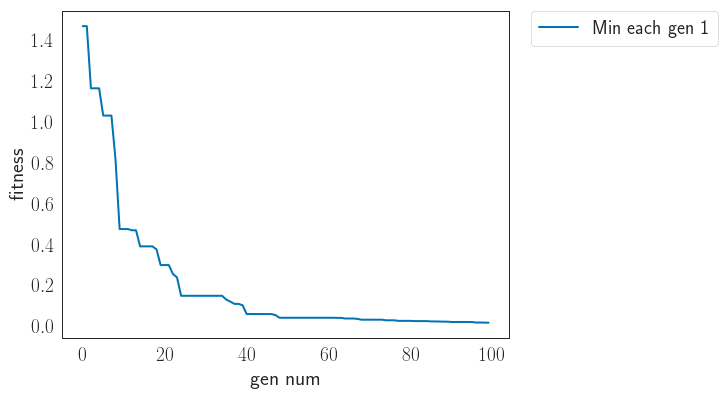

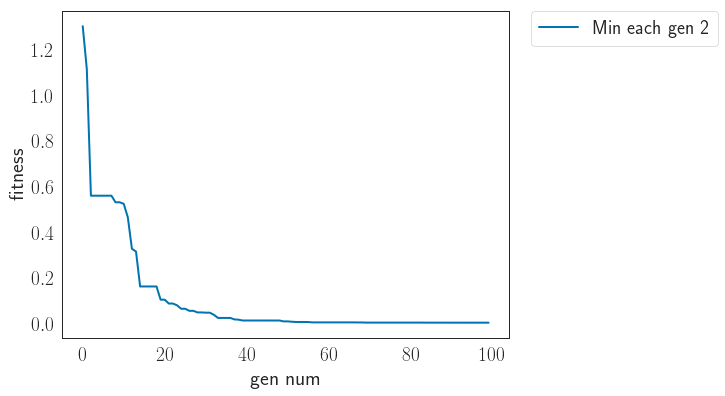

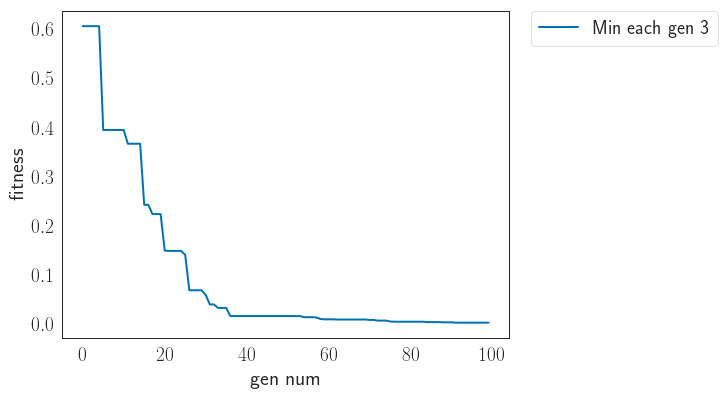

In [198]:
plt.plot(range(num_geracoes), min_gen_1, label="Min each gen 1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('gen num')
plt.ylabel('fitness')
plt.show()

plt.plot(range(num_geracoes), min_gen_2, label="Min each gen 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('gen num')
plt.ylabel('fitness')
plt.show()

plt.plot(range(num_geracoes), min_gen_3, label="Min each gen 3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('gen num')
plt.ylabel('fitness')
plt.show()